In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()

from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

Using TensorFlow backend.


UMPM


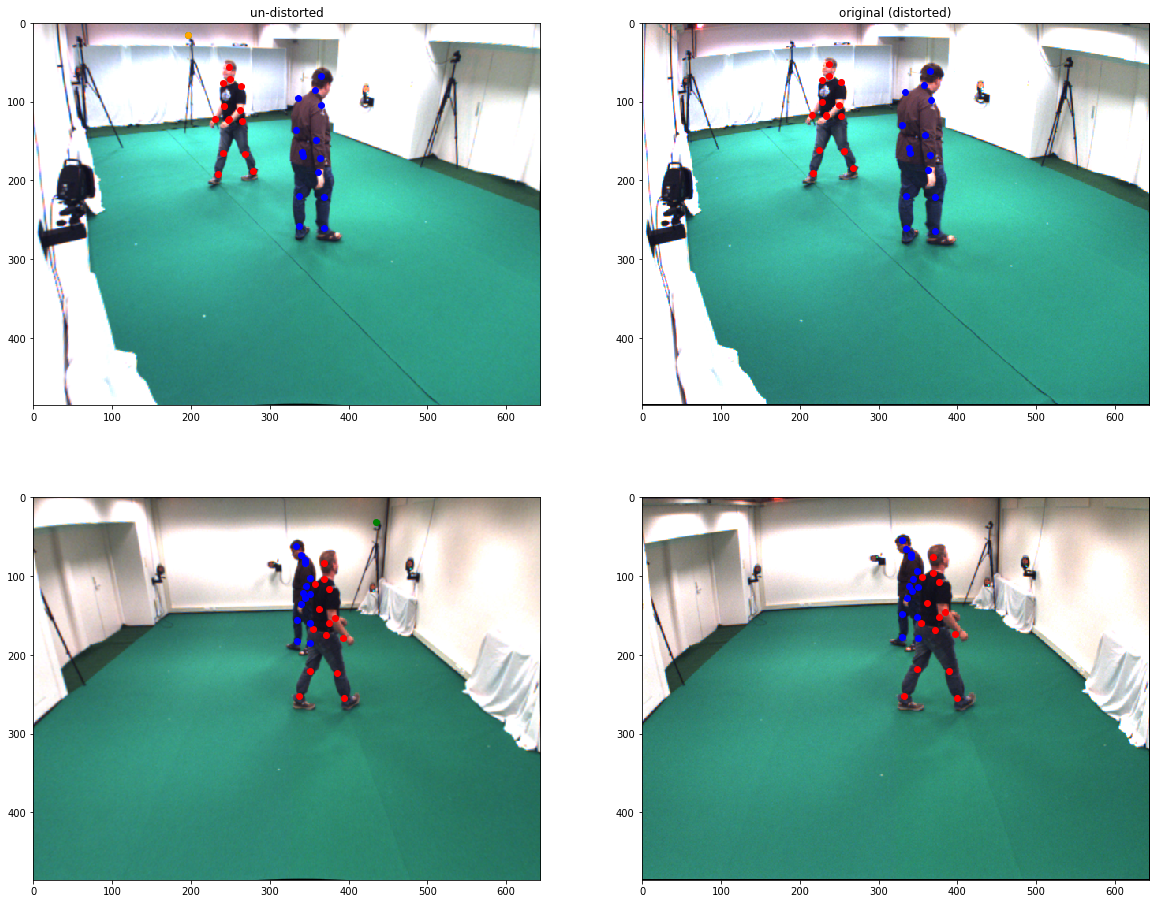

In [2]:
Frame = 999

from mvpose.geometry import stereo
from mvpose.geometry import geometry as gm

K1, rvec1, tvec1, distCoef1 = gm.get_camera_parameters(Calib[1])
K2, rvec2, tvec2, distCoef2 = gm.get_camera_parameters(Calib[2])

c1 = gm.get_camera_pos_in_world_coords(Calib[1])
c2 = gm.get_camera_pos_in_world_coords(Calib[2])


#e2, e1 = stereo.get_epipoles(Calib[1], Calib[2])

Im1 = X[1][Frame]; Im2 = X[2][Frame]
Im1_ud, K1_ud = gm.remove_distortion(Im1, Calib[1])
Im2_ud, K2_ud = gm.remove_distortion(Im2, Calib[2])
P1 = gm.get_projection_matrix_flat(K1_ud, rvec1, tvec1)
P2 = gm.get_projection_matrix_flat(K2_ud, rvec2, tvec2)

e2, e1 = stereo.get_epipoles_undistorted(K1_ud, rvec1, tvec1, K2_ud, rvec2, tvec2)

uv2 = gm.from_homogeneous(P1@gm.to_homogeneous(c2))
uv1 = gm.from_homogeneous(P2@gm.to_homogeneous(c1))

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(221)
ax.imshow(Im1_ud)
ax.scatter(uv2[0], uv2[1], color='green')
ax.scatter(e2[0], e2[1], color='orange')


ax_r = fig.add_subplot(222)
ax_r.imshow(Im1)

ay = fig.add_subplot(223)
ay.imshow(Im2_ud)
ay.scatter(uv1[0], uv1[1], color='green')

ay_r = fig.add_subplot(224)
ay_r.imshow(Im2)

ax.set_title('un-distorted')
ax_r.set_title('original (distorted)')


color = ['red', 'blue']
for x,y,z,pid in Y[Frame]:
    p = gm.to_homogeneous([x,y,z])
    u, v = gm.from_homogeneous(P1@p)
    ax.scatter(u,v, color=color[int(pid)])
    
    u, v = np.squeeze(cv2.projectPoints(np.array([[x,y,z]]), 
                                 rvec1, tvec1, K1, distCoef1)[0])
    ax_r.scatter(u,v,color=color[int(pid)])
    
    u, v = gm.from_homogeneous(P2@p)
    ay.scatter(u,v, color=color[int(pid)])
    
    u, v = np.squeeze(cv2.projectPoints(np.array([[x,y,z]]), 
                                 rvec2, tvec2, K2, distCoef2)[0])
    ay_r.scatter(u,v,color=color[int(pid)])

plt.show()